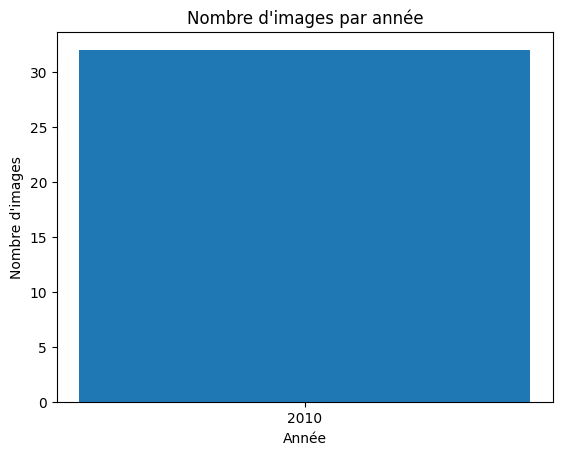

ValueError: input operand has more dimensions than allowed by the axis remapping

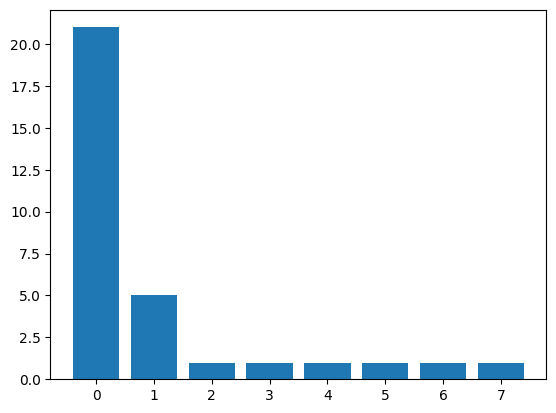

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialiser une session Spark
spark = SparkSession.builder.appName("ImageAnalysis").getOrCreate()

# Définir le répertoire contenant les images
image_dir = 'images'

# Créer un RDD à partir de la liste des noms de fichiers d'images
image_files_rdd = spark.sparkContext.parallelize(os.listdir(image_dir))

# Filtrer les noms de fichiers d'images valides
valid_image_files_rdd = image_files_rdd.filter(lambda filename: filename.endswith((".jpg", ".png", ".jpeg")))

# Mapper pour ouvrir les images avec la bibliothèque PIL et extraire les informations
def extract_image_info(filename):
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path)
    year = image._getexif().get(36867)[:4]  # Extraire l'année de la date de création de l'image
    size = image.size
    if size[0] > size[1]:
        orientation = "Paysage"
    else:
        orientation = "Portrait"
    camera = image._getexif().get(271)
    colors = image.getcolors()
    return (year, size, orientation, camera, colors)

image_info_rdd = valid_image_files_rdd.map(extract_image_info)

# Reducer pour compter les occurrences des informations
def count_occurrences(acc, info):
    year_counts, size_counts, orientation_counts, camera_counts, color_counts = acc
    year, size, orientation, camera, colors = info
    
    if year in year_counts:
        year_counts[year] += 1
    else:
        year_counts[year] = 1
    
    if size in size_counts:
        size_counts[size] += 1
    else:
        size_counts[size] = 1
    
    if orientation in orientation_counts:
        orientation_counts[orientation] += 1
    else:
        orientation_counts[orientation] = 1
    
    if camera in camera_counts:
        camera_counts[camera] += 1
    else:
        camera_counts[camera] = 1
    
    if colors in color_counts:
        color_counts[colors] += 1
    else:
        color_counts[colors] = 1
    
    return (year_counts, size_counts, orientation_counts, camera_counts, color_counts)

initial_counts = ({}, {}, {}, {}, {})
result = image_info_rdd.aggregate(initial_counts, count_occurrences, count_occurrences)

# Fermer la session Spark
spark.stop()

# Visualiser les informations collectées
year_counts = result[0]
size_counts = result[1]
orientation_counts = result[2]
camera_counts = result[3]
color_counts = result[4]

# Nombre d'images par année
plt.bar(year_counts.keys(), year_counts.values())
plt.title("Nombre d'images par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'images")
plt.show()

# Nombre d'images par taille
sizes = list(size_counts.keys())
counts = list(size_counts.values())
plt.bar(range(len(size_counts)), counts, tick_label=sizes)
plt.title("Nombre d'images par taille")
plt.xlabel("Taille de l'image")
plt.ylabel("Nombre d'images")
plt.show()

# Nombre d'images par orientation
orientations = list(orientation_counts.keys())
counts = list(orientation_counts.values())
plt.pie(counts, labels=orientations, autopct='%1.1f%%')
plt.title("Répartition des orientations d'images")
plt.show()

# Nombre d'images par modèle d'appareil photo
cameras = list(camera_counts.keys())
counts = list(camera_counts.values())
plt.bar(range(len(camera_counts)), counts, tick_label=cameras)
plt.title("Nombre d'images par modèle d'appareil photo")
plt.xlabel("Modèle d'appareil photo")
plt.ylabel("Nombre d'images")
plt.show()

# Caractéristiques de couleurs
color_counts_sorted = dict(sorted(color_counts.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(8, 6))
plt.bar(color_counts_sorted.keys(), color_counts_sorted.values())
plt.title('Caractéristiques de couleurs')
plt.xlabel('Couleur')
plt.ylabel('Nombre d\'images')
plt.show()
